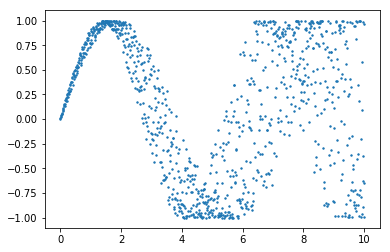

In [142]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Data
n = 1000
x = np.linspace(0,10,n)
epis = np.random.uniform(-1,1,n)
y = np.sin(x + epis * (x/5)**1.1)

plt.scatter(x, y, s = 2)

In [143]:
x = x.reshape(n, 1)
x.shape

(1000, 1)

## Non-Bayesian

In [144]:
# Network parameter
n_inputs = 1
n_hidden1 = 100
n_hidden2 = 50
n_outputs = 1

# tf Graph input
X_tf = tf.placeholder(tf.float32,
                  shape = (None, n_inputs),
                  name = 'X')
y_tf = tf.placeholder(tf.float32,
                  shape = (None),
                  name = 'y')

# Paraameters
learning_rate = 0.1
num_steps = 4000
batch_size = 100
display_step = 500

# Layer weights and bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_inputs, n_hidden1])),
    'h2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
    'out': tf.Variable(tf.random_normal([n_hidden2, n_outputs])), 
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden1])),
    'b2': tf.Variable(tf.random_normal([n_hidden2])),
    'out': tf.Variable(tf.random_normal([n_outputs])), 
}

# Model
def neural_net(x):
    # Hidden fully connected
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    #layer_1 = tf.nn.dropout(layer_1, keep_prob=0.8)
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    #layer_2 = tf.nn.dropout(layer_2, keep_prob=0.8)
    # Output
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    
    return out_layer

In [145]:
# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
loss_op = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model

# Initialize the variables
init = tf.global_variables_initializer()

In [146]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        #batch_x = np.random.choice(x[:,0], batch_size).reshape(batch_size, 1)
        #batch_y = np.random.choice(y, batch_size)
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred = sess.run(NN, feed_dict={X_tf: x})


step 1, Minibatch Loss = 146647.27
step 500, Minibatch Loss = 0.30871513
step 1000, Minibatch Loss = 0.25061563
step 1500, Minibatch Loss = 0.22257172
step 2000, Minibatch Loss = 0.20190893
step 2500, Minibatch Loss = 0.18732196
step 3000, Minibatch Loss = 35.741856
step 3500, Minibatch Loss = 0.1982316
step 4000, Minibatch Loss = 0.17755476
optimization finished


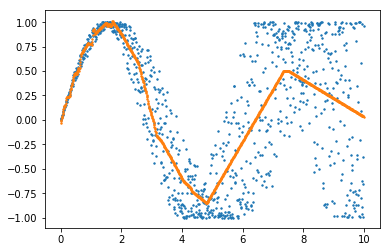

In [147]:
plt.scatter(x, y, s = 2)
plt.scatter(x, pred, s = 2)


## Bayesian

In [148]:
neural_net = tf.keras.Sequential([
    tfp.layers.DenseFlipout(512, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(256, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(1),
])

# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
loss_op = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables
init = tf.global_variables_initializer()

In [149]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    # Draw sample for the weights from the posterior
    w_draw = []
    pred = []
    for i in range(5):
        w_draw.append(neural_net.layers[0].kernel_posterior.sample().eval())
        pred.append(sess.run(NN, feed_dict={X_tf: x}))


step 1, Minibatch Loss = 154332.84
step 500, Minibatch Loss = 0.18107155
step 1000, Minibatch Loss = 0.170908
step 1500, Minibatch Loss = 0.33793202
step 2000, Minibatch Loss = 0.33769226
step 2500, Minibatch Loss = 0.3376436
step 3000, Minibatch Loss = 0.3377784
step 3500, Minibatch Loss = 0.33769467
step 4000, Minibatch Loss = 0.33771127
optimization finished


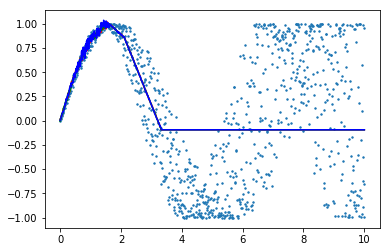

In [150]:
plt.scatter(x, y, s = 2)
plt.plot(x, pred[0], c = 'r')
plt.plot(x, pred[1], c = 'g')
plt.plot(x, pred[2],  c = 'b')


